# Behavior Cloning

This notebook is a demo of the same *model.py* file in the repository for interactive computing purposes. While there may be some options added the the notebook, the main underlying functions and methods used *model.py* are the same.

## Import libraries

Here we will import all the essential libraries.

In [1]:
import os
import csv
import cv2
import numpy as np
import keras
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import math

from scipy import ndimage

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Cropping2D
from keras.layers import Dropout

import sklearn
from sklearn.model_selection import train_test_split

import GPUtil as GPU

Using TensorFlow backend.


## GPU information

Here, we will print some information related to GPU memory capacity. The user can accordingly make modifications to the code in case of more/less capacity.

In [2]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("Total Available GPU memory: {} MB".format(gpu.memoryTotal))
print("Used GPU memory: {} MB".format(gpu.memoryUsed))
print("Total Free GPU memory: {} MB".format(gpu.memoryFree))

Total Available GPU memory: 4096.0 MB
Used GPU memory: 716.0 MB
Total Free GPU memory: 3380.0 MB


## Check library versions

Here, we print the versions of tensorflow, keras and OpenCV versions to compare compatibility.

In [3]:
# printing installed tensorflow/keras/OpenCV versions
print("Current OpenCV version:", cv2.__version__)
print("Using TensorFlow version:", tf.__version__)
print("Using Keras version:", keras.__version__)


Current OpenCV version: 4.2.0
Using TensorFlow version: 1.15.0
Using Keras version: 2.3.1


## Dataset building and Augmentation

Here, we load the data from the *driving_log.csv* file and if required augment the data by flipping the images in the opposite direction.

In [4]:
# 1. Start of dataset building
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
directory = './data/IMG/'

# steering angle correction
correction = 0.25

# setting data augmentation activation to True/False
augment = True

if (augment):
    print("Performing data augmentation by flipping the images ...\n")

for line in lines:

    # reading filesnames for center, left and right images
    fname_center = directory + line[0].split('/')[-1]
    fname_left = directory + line[1].split('/')[-1]
    fname_right = directory + line[2].split('/')[-1]

    # reading images using opencv
    img_center = mpimg.imread(fname_center)
    img_left = mpimg.imread(fname_left)
    img_right = mpimg.imread(fname_right)

    # adding images to the lists
    images.append(img_center)
    images.append(img_left)
    images.append(img_right)

    # adding steering angles for center. left and right images
    measurements.append(float(line[3]))
    measurements.append(float(line[3])+correction)  # for left image
    measurements.append(float(line[3])-correction)  # for right image

    # only if data augmentation is required
    if (augment):
        # this is where I perform data augmentation for images and angles
        center_flipped = np.fliplr(img_center)
        images.append(center_flipped)
        center_measurement_flipped = -(float(line[3]))
        measurements.append(center_measurement_flipped)

        left_flipped = np.fliplr(img_left)
        images.append(left_flipped)
        left_measurement_flipped = -(float(line[3])+correction)
        measurements.append(left_measurement_flipped)

        right_flipped = np.fliplr(img_right)
        images.append(right_flipped)
        right_measurement_flipped = -(float(line[3])-correction)
        measurements.append(right_measurement_flipped)


# define arrays for datasets
X_train = np.array(images)
steering_angles = np.array(measurements)

Performing data augmentation by flipping the images ...



## Sample Flip Images

This is the procedure I used to augment the data. The image was flipped from left to right. Here is a sample flipped image.

<Figure size 432x288 with 0 Axes>

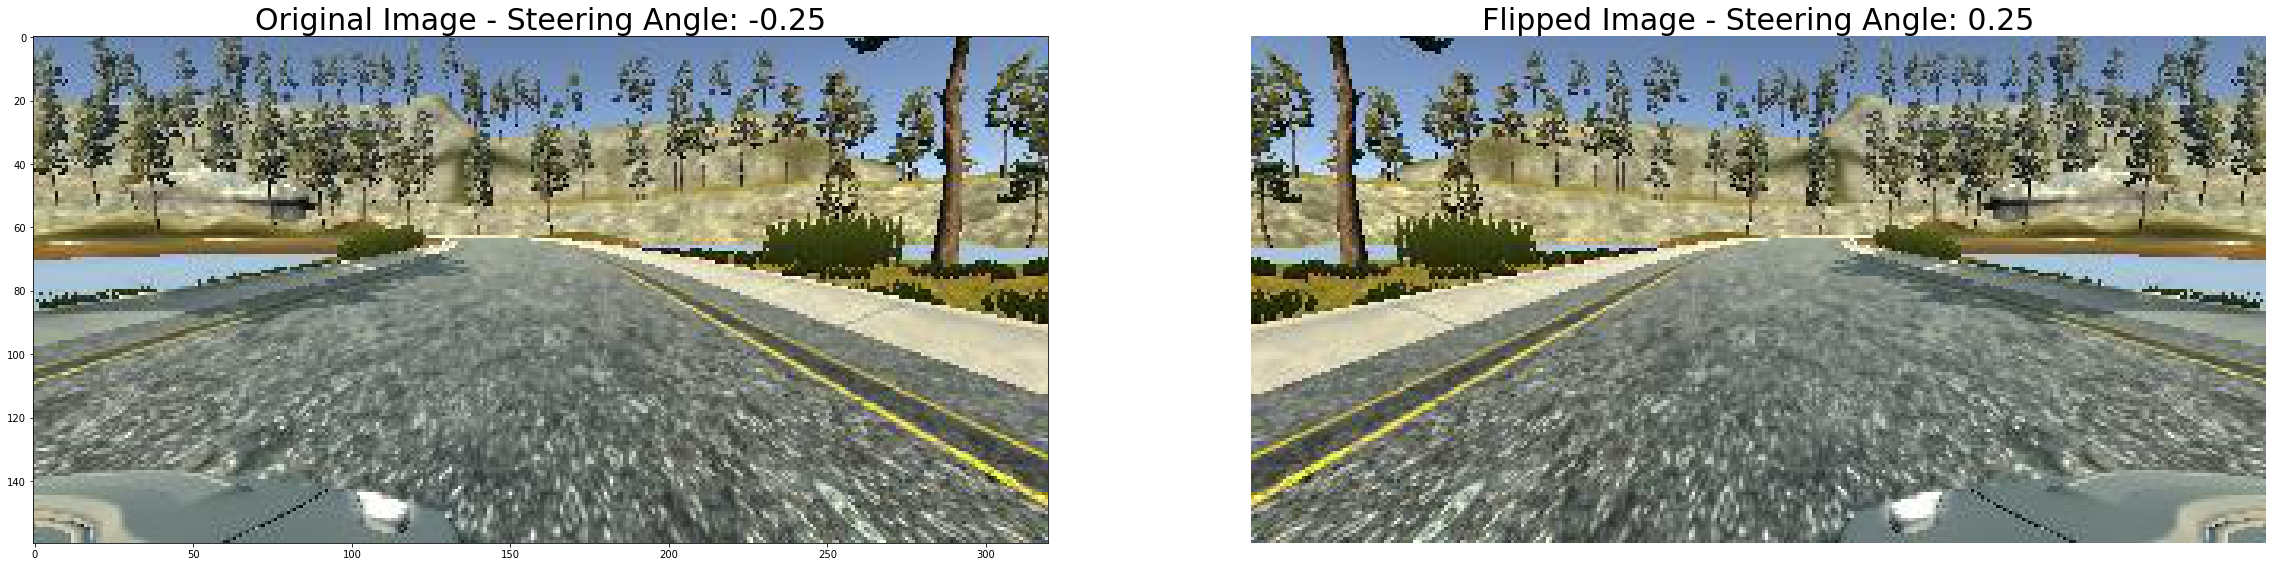

In [5]:
idx = random.randint(0, len(X_train))
img = X_train[idx]
flipped_img = np.fliplr(img)
angle_val = steering_angles[idx]

flipped_angle_val = -float(angle_val)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

ax1.imshow(img)
ax1.set_title('Original Image - Steering Angle: ' + str(angle_val), fontsize=30)
ax2.imshow(flipped_img)
ax2.set_title('Flipped Image - Steering Angle: ' + str(flipped_angle_val), fontsize=30)

plt.axis('off')
plt.show()


### Print Dataset information

We will print information regarding the dataset here. We will also print information after data augmentation.

In [6]:
# function to print the dataset information
def print_dataset_info():

    if (augment):
        # print out array shapes and details
        print("Original Dataset information ---\n")
        # print("Image shape: ", X_train[0][1])
        print("Steering Angles:", 0.5*len(steering_angles))
        print("Total images:", 0.5*X_train.shape[0])
        print()

        print("Augmented Dataset information ---\n")
        # print("Image shape: ", X_train[0][1])
        print("Steering Angles after augmentation:", len(steering_angles))
        print("Total images after augmentation:", X_train.shape[0])
        print()
    else:
        # print out array shapes and details
        print("Original Dataset information ---\n")
        # print("Image shape: ", X_train[0][1])
        print("Steering Angles:", 0.5*len(steering_angles))
        print("Total images:", 0.5*X_train.shape[0])

In [7]:
print_dataset_info()

Original Dataset information ---

Steering Angles: 13590.0
Total images: 13590.0

Augmented Dataset information ---

Steering Angles after augmentation: 27180
Total images after augmentation: 27180



### Display a sample image

Here, we display a random sample image captured by the center camera of the car. We also print some characteristics of the image.

(160, 320, 3)


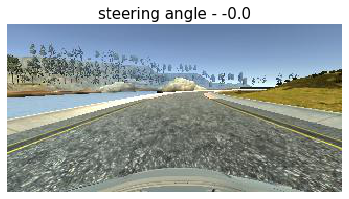

In [8]:
idx = random.randint(0, len(X_train))
sample_img = X_train[idx]
print(sample_img.shape)
plt.imshow(sample_img)
plt.axis('off')
plt.title("steering angle - " + str(steering_angles[idx]), fontsize=15)
plt.show()


### Display images

We will randomly display a few for demonstration here.

In [9]:
# function to display some images
def disp_images():
    fig1 = plt.figure()
    fig1, ax = plt.subplots(2, 2, figsize=(100, 30))
    ax = ax.ravel()
    for i in range(4):
        index = random.randint(0, len(X_train))
        image = X_train[index]
        ax[i].imshow(image)
        plt.axis('off')
        ax[i].set_title("steering angle: " + str(steering_angles[index]), fontsize=50)

    # saving the figure
    # mpimg.imsave('./examples/sample_images.jpg', fig1)
    plt.show()

<Figure size 432x288 with 0 Axes>

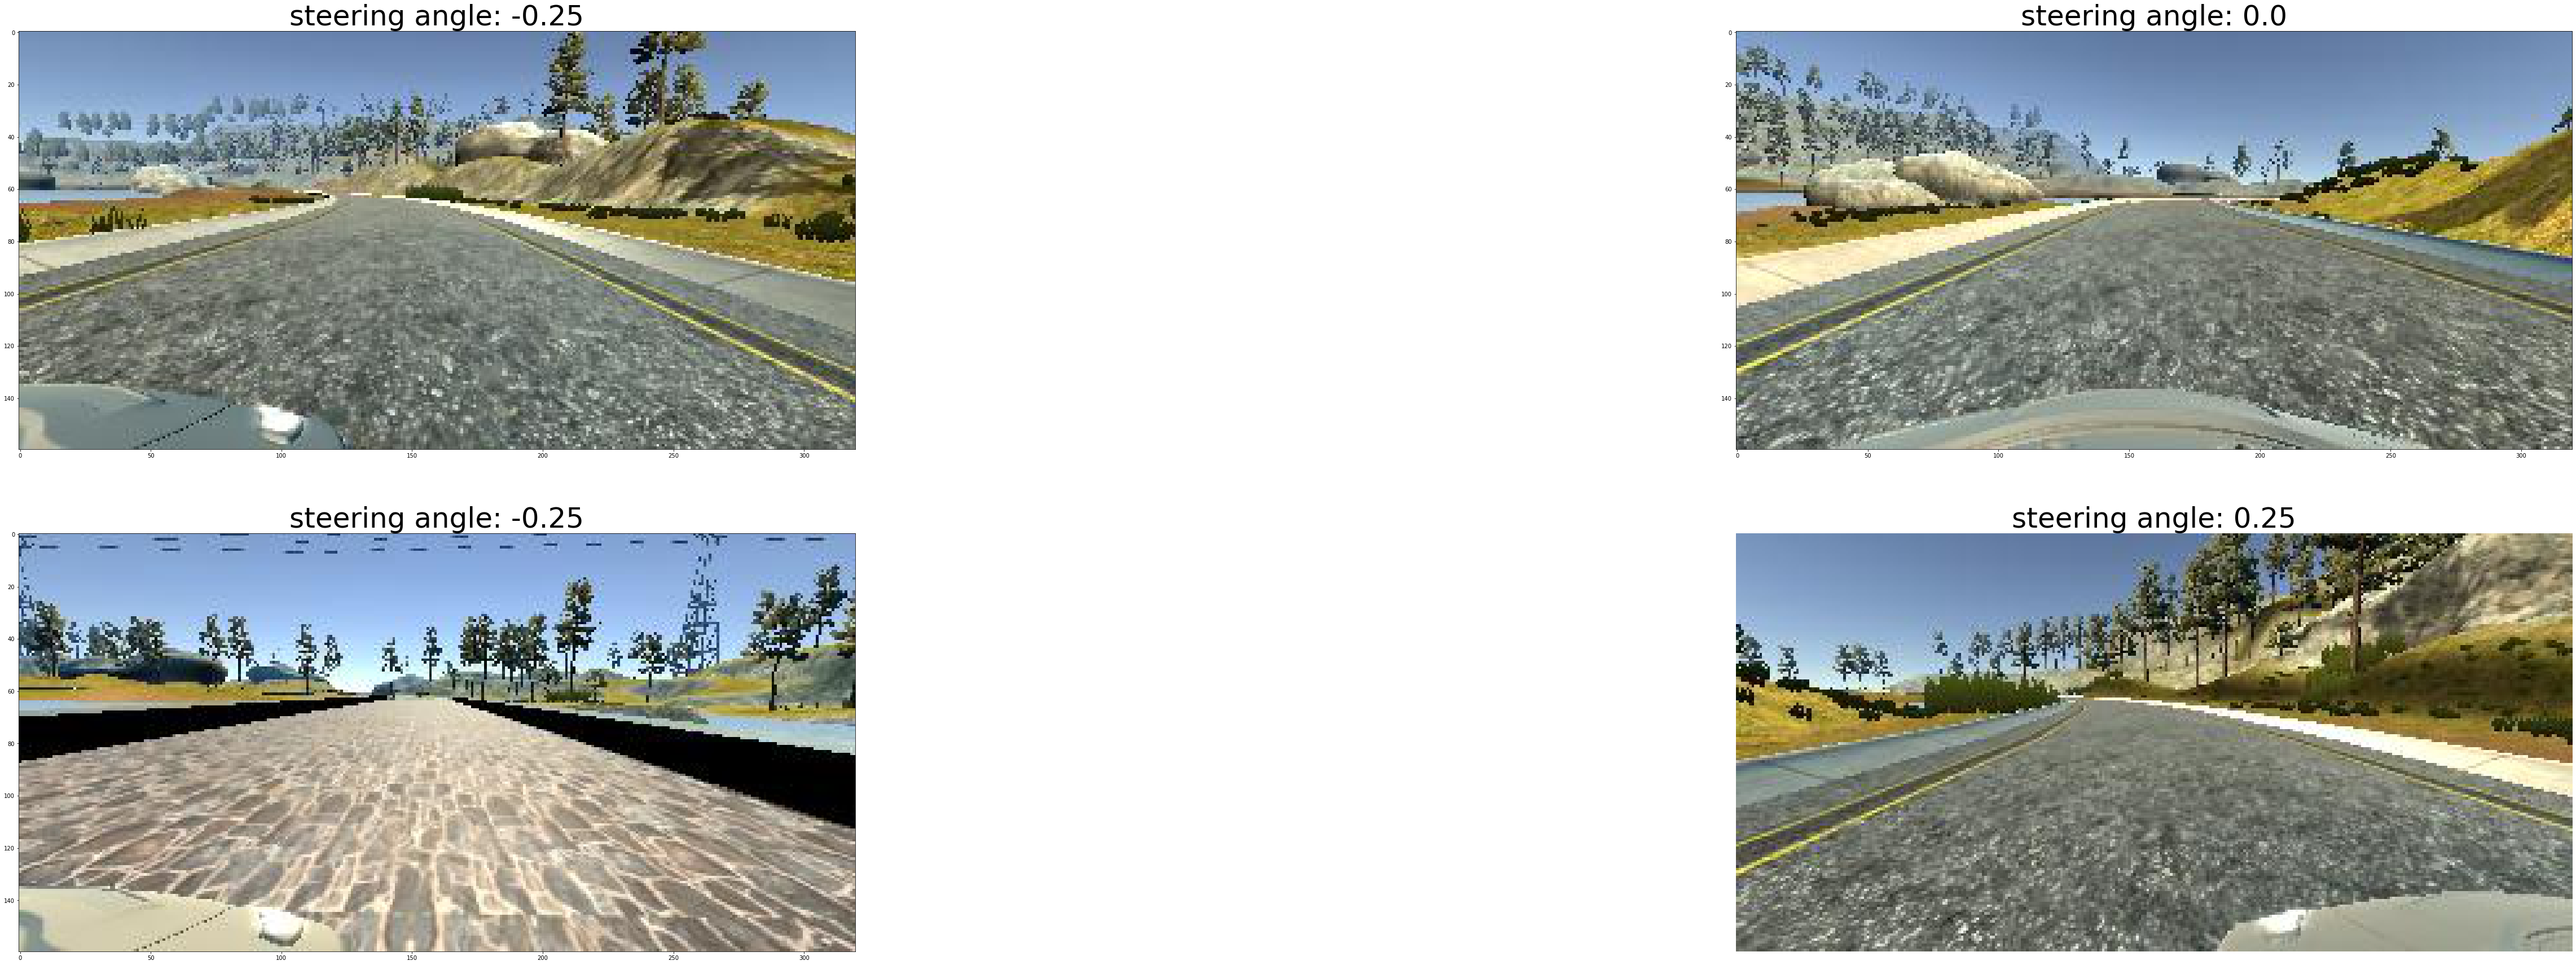

In [10]:
disp_images()

## Network Architecture

Now, we will define our Convolutional Neural Network here comtaining 6 convolutional layers, 4 fully connected layers and some dropout and lambda layers in between. We will use a dropout layer after the 6th convolutional layers and set the number of epochs to 10.


In [11]:

# 2. Start of Network Architecture
# NVIDIA network architecture
model = Sequential()

# image preprocessing - normalizing the pixel values and cropping the image
model.add(Lambda(lambda x:(x/127.5)-1.0, input_shape=(160,320,3)))
# cropping top 50 pixels and 20 pixels from the bottom
model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape=(160,320,3)))

# 1st Convolutional layer
model.add(Conv2D(24, (5, 5), subsample = (2,2), activation="relu"))
# 2nd Convolutional layer
model.add(Conv2D(36, (5, 5), subsample = (2,2), activation="relu"))
# 3rd Convolutional layer
model.add(Conv2D(48, (5, 5), subsample = (2,2), activation="relu"))
# 4th Convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))
# 5th Convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))
# 6th Convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))

model.add(Dropout(0.5))

# flatten layers into a vector
model.add(Flatten())

# four fully connected layers
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer ='adam')

# fit model with a validation set of 20%
history_object = model.fit(X_train, steering_angles, validation_split=0.2, shuffle=True, epochs=10)

model.save('model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Users\gborgaonkar\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\gborgaonkar\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  del sys.path[0]
C:\Users\gborgaonkar\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  from ipykernel import kernelapp as app



Train on 21744 samples, validate on 5436 samples
Epoch 1/10
21744/21744 [==============================] - 43s 2ms/step - loss: 0.0403 - val_loss: 0.0550
Epoch 2/10
21744/21744 [==============================] - 42s 2ms/step - loss: 0.0343 - val_loss: 0.0592
Epoch 3/10
21744/21744 [==============================] - 42s 2ms/step - loss: 0.0316 - val_loss: 0.0533
Epoch 4/10
21744/21744 [==============================] - 43s 2ms/step - loss: 0.0291 - val_loss: 0.0545
Epoch 5/10
21744/21744 [==============================] - 41s 2ms/step - loss: 0.0270 - val_loss: 0.0550
Epoch 6/10
21744/21744 [==============================] - 42s 2ms/step - loss: 0.0240 - val_loss: 0.0574
Epoch 7/10
21744/21744 [==============================] - 42s 2ms/step - loss: 0.0219 - val_loss: 0.0611
Epoch 8/10
21744/21744 [==============================] - 42s 2ms/step - loss: 0.0198 - val_loss: 0.0603
Epoch 9/10
21744/21744 [==============================] - 42s 2ms/step - loss: 0.0184 - val_loss: 0.0630
Epoch

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)        

dict_keys(['val_loss', 'loss'])


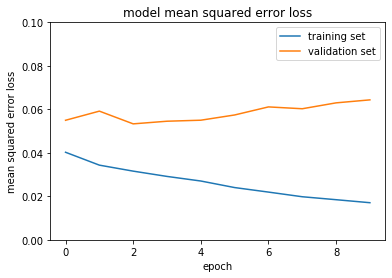

In [13]:
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.ylim(0,0.1)
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
